# Implied Vol and Model Calibration with Market Data

In [1]:
import pandas as pd
import scipy.optimize as scpo
import numpy as np
from rivapy.models.heston_for_DH import HestonForDeepHedging
from rivapy.models.gbm import GBM
from rivapy.models.heston_with_jumps import HestonWithJumps
from rivapy.models.barndorff_nielsen_shephard import BNS
import matplotlib.pyplot as plt

C:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [2]:
arbitragePoits=[ ]
expiries=[ "20220617T130000" , "20220715T130000" , "20220819T130000" , "20220916T130000" , "20221216T130000" , "20230317T130000" , "20230616T130000" , "20230915T130000" , "20231215T130000" ] 
fwds=[ "14045.4" , "14038.3" , "14027.9" , "14028.1" , "14032.2" , "14056.7" , "14132.8" , "14172.6" , "14212.6" ] 
bidPuts=[ [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 ,
13950 , 14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 ,
14400 ]  , [ 0.238144 , 0.235407 , 0.232285 , 0.230456 , 0.226755 ,
0.223255 , 0.220656 , 0.218917 , 0.215529 , 0.213342 , 0.207465 ,
0.204589 , 0.202247 , 0.196842 , 0.195847 , 0.193276 , 0.190076 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.237794 , 0.236191 , 0.232928 , 0.231202 , 0.228533 , 0.226945 ,
0.223982 , 0.221416 , 0.218713 , 0.216619 , 0.21377 , 0.211554 ,
0.207902 , 0.206344 , 0.204288 , 0.201152 , 0.199363 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.239283 , 0.236953 , 0.235547 , 0.233148 , 0.230915 , 0.228974 ,
0.227294 , 0.224823 , 0.223084 , 0.220501 , 0.219257 , 0.216428 ,
0.212525 , 0.209832 , 0.207799 , 0.206982 , 0.203981 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.239294 , 0.235496 , 0.232044 , 0.226647 , 0.223138 ,
0.219084 , 0.215369 , 0.211758 , 0.207395 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.235505 , 0.232255 , 0.228659 , 0.225915 , 0.225259 ,
0.220014 , 0.216355 , 0.213245 , 0.209952 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.230885 , 0.228358 , 0.22538 , 0.22336 , 0.220538 ,
0.217494 , 0.21472 , 0.212425 , 0.210041 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.220101 , 0.217755 , 0.215391 , 0.213003 , 0.21076 ,
0.208237 , 0.206154 , 0.203669 , 0.20128 ] ]
  , [[ 13600 , 13800 , 14000 , 14200 , 14400 ]  , [ 0.218103 , 0.214064 , 0.20984 , 0.20575 , 0.201622 ] ]
  , [[ 13600 , 13800 , 14000 , 14200 , 14400 ]  , [ 0.215749 , 0.211977 , 0.208079 , 0.20436 , 0.200527 ] ] ] 

askPuts=[ [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 ,
13950 , 14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 ,
14400 ]  , [ 0.245392 , 0.242337 , 0.240298 , 0.237905 , 0.233705 ,
0.230801 , 0.22807 , 0.226241 , 0.222198 , 0.221307 , 0.218314 ,
0.214796 , 0.211838 , 0.213671 , 0.207348 , 0.205061 , 0.203769 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.243011 , 0.241896 , 0.238021 , 0.236219 , 0.233492 , 0.230875 ,
0.229345 , 0.226733 , 0.224504 , 0.222399 , 0.219542 , 0.218264 ,
0.216132 , 0.213165 , 0.211666 , 0.209137 , 0.206938 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.243967 , 0.241975 , 0.240522 , 0.237706 , 0.235441 , 0.233801 ,
0.231772 , 0.229281 , 0.227903 , 0.225311 , 0.224061 , 0.221235 ,
0.22096 , 0.218747 , 0.216753 , 0.215988 , 0.212685 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.242982 , 0.23913 , 0.235961 , 0.231824 , 0.227965 ,
0.224537 , 0.220824 , 0.216753 , 0.213247 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.240451 , 0.237151 , 0.234 , 0.230979 , 0.227904 ,
0.224305 , 0.221847 , 0.218501 , 0.215462 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.238696 , 0.2359 , 0.233474 , 0.2308 , 0.228176 , 0.225303 , 0.222872 , 0.22037 , 0.217791 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.238844 , 0.236522 , 0.234196 , 0.232037 , 0.229689 ,
0.227506 , 0.225104 , 0.223269 , 0.221202 ] ]
  , [[ 13600 , 13800 , 14000 , 14200 , 14400 ]  , [ 0.236803 , 0.232804 , 0.228829 , 0.224891 , 0.221136 ] ]
  , [[ 13600 , 13800 , 14000 , 14200 , 14400 ]  , [ 0.234446 , 0.230693 , 0.227004 , 0.223404 , 0.220031 ] ] ] 

bidCalls=[ [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 ,
13950 , 14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 ,
14400 ]  , [ 0.234667 , 0.231708 , 0.229058 , 0.227708 , 0.224852 ,
0.221775 , 0.219588 , 0.216411 , 0.213785 , 0.210167 , 0.209371 ,
0.206524 , 0.203482 , 0.201522 , 0.198698 , 0.196214 , 0.193567 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.235404 , 0.234871 , 0.23216 , 0.229457 , 0.227321 , 0.224778 ,
0.222335 , 0.219799 , 0.217597 , 0.215522 , 0.214132 , 0.211931 ,
0.209751 , 0.207246 , 0.205708 , 0.20261 , 0.200851 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.236454 , 0.234558 , 0.232425 , 0.230828 , 0.228628 , 0.226741 ,
0.224692 , 0.222621 , 0.220533 , 0.218711 , 0.219334 , 0.217261 ,
0.214467 , 0.211817 , 0.210929 , 0.208271 , 0.206814 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.23777 , 0.234358 , 0.230299 , 0.226568 , 0.222771 ,
0.219071 , 0.215067 , 0.211494 , 0.207478 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.235151 , 0.231914 , 0.228817 , 0.225359 , 0.222552 ,
0.219722 , 0.216313 , 0.213213 , 0.21017 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.230896 , 0.228133 , 0.225328 , 0.222674 , 0.219621 ,
0.21755 , 0.214745 , 0.212618 , 0.209607 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.22127 , 0.218838 , 0.216568 , 0.214273 , 0.210021 ,
0.207596 , 0.205442 , 0.203063 , 0.200774 ] ]
  , [[],[]]
  , [[],[]]
]

askCalls=[ [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 ,
13950 , 14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 ,
14400 ]  , [ 0.248316 , 0.246066 , 0.242684 , 0.238691 , 0.236427 ,
0.233093 , 0.229226 , 0.226666 , 0.223396 , 0.218857 , 0.216603 ,
0.213814 , 0.210859 , 0.208557 , 0.205596 , 0.203673 , 0.20078 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.245317 , 0.242134 , 0.239797 , 0.237986 , 0.23476 , 0.232638 ,
0.230136 , 0.227534 , 0.224837 , 0.223228 , 0.219423 , 0.217203 ,
0.215076 , 0.212605 , 0.210626 , 0.208099 , 0.206404 ] ]
  , [[ 13600 , 13650 , 13700 , 13750 , 13800 , 13850 , 13900 , 13950 ,
14000 , 14050 , 14100 , 14150 , 14200 , 14250 , 14300 , 14350 , 14400 ] , [ 0.246212 , 0.244215 , 0.241612 , 0.239943 , 0.237681 , 0.235652 ,
0.233275 , 0.231909 , 0.229059 , 0.227591 , 0.224138 , 0.221698 ,
0.219235 , 0.217017 , 0.215779 , 0.213151 , 0.211732 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.243471 , 0.239975 , 0.23585 , 0.232392 , 0.228563 ,
0.224844 , 0.220842 , 0.217183 , 0.21333 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.240838 , 0.237545 , 0.234401 , 0.231388 , 0.228081 ,
0.224492 , 0.221805 , 0.218708 , 0.215441 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.238913 , 0.236083 , 0.233624 , 0.230918 , 0.227862 ,
0.22556 , 0.222897 , 0.220365 , 0.217755 ] ]
  , [[ 13600 , 13700 , 13800 , 13900 , 14000 , 14100 , 14200 , 14300 ,
14400 ]  , [ 0.240912 , 0.236532 , 0.234131 , 0.231721 , 0.229475 ,
0.227219 , 0.224741 , 0.222663 , 0.220523 ] ]
  , [[],[]]
  , [[],[]]
]

bidPutsCalib=[ [[ 14000 , 14050 , 14100 , 14150 ]  , [ 0.215529 ,
0.213342 , 0.207465 , 0.204589 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.221416 , 0.218713 ,
0.216619 , 0.21377 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.224823 , 0.223084 ,
0.220501 , 0.219257 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.226647 , 0.223138 ,
0.219084 , 0.215369 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.225915 , 0.225259 ,
0.220014 , 0.216355 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.22336 , 0.220538 ,
0.217494 , 0.21472 ] ]
  , [[ 14000 , 14100 , 14200 , 14300 ]  , [ 0.21076 , 0.208237 ,
0.206154 , 0.203669 ] ]
  , [[ 13800 , 14000 , 14200 , 14400 ]  , [ 0.214064 , 0.20984 , 0.20575 , 0.201622 ] ]
  , [[ 13800 , 14000 , 14200 , 14400 ]  , [ 0.211977 , 0.208079 ,
0.20436 , 0.200527 ] ]
]

askPutsCalib=[ [[ 14000 , 14050 , 14100 , 14150 ]  , [ 0.222198 ,
0.221307 , 0.218314 , 0.214796 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.226733 , 0.224504 ,
0.222399 , 0.219542 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.229281 , 0.227903 ,
0.225311 , 0.224061 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.231824 , 0.227965 ,
0.224537 , 0.220824 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.230979 , 0.227904 ,
0.224305 , 0.221847 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.2308 , 0.228176 , 0.225303 , 0.222872 ] ]
  , [[ 14000 , 14100 , 14200 , 14300 ]  , [ 0.229689 , 0.227506 ,
0.225104 , 0.223269 ] ]
  , [[ 13800 , 14000 , 14200 , 14400 ]  , [ 0.232804 , 0.228829 ,
0.224891 , 0.221136 ] ]
  , [[ 13800 , 14000 , 14200 , 14400 ]  , [ 0.230693 , 0.227004 ,
0.223404 , 0.220031 ] ]
]

bidCallsCalib=[ [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.216411 ,
0.213785 , 0.210167 , 0.209371 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.219799 , 0.217597 ,
0.215522 , 0.214132 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.222621 , 0.220533 ,
0.218711 , 0.219334 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.226568 , 0.222771 ,
0.219071 , 0.215067 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.225359 , 0.222552 ,
0.219722 , 0.216313 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.222674 , 0.219621 ,
0.21755 , 0.214745 ] ]
  , [[ 14000 , 14100 , 14200 , 14300 ]  , [ 0.210021 , 0.207596 ,
0.205442 , 0.203063 ] ]
  , [[],[]]
  , [[],[]]
]

askCallsCalib=[ [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.226666 ,
0.223396 , 0.218857 , 0.216603 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.227534 , 0.224837 ,
0.223228 , 0.219423 ] ]
  , [[ 13950 , 14000 , 14050 , 14100 ]  , [ 0.231909 , 0.229059 ,
0.227591 , 0.224138 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.232392 , 0.228563 ,
0.224844 , 0.220842 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.231388 , 0.228081 ,
0.224492 , 0.221805 ] ]
  , [[ 13900 , 14000 , 14100 , 14200 ]  , [ 0.230918 , 0.227862 ,
0.22556 , 0.222897 ] ]
  , [[ 14000 , 14100 , 14200 , 14300 ]  , [ 0.229475 , 0.227219 ,
0.224741 , 0.222663 ] ]
  , [[],[]]
  , [[],[]]
]

theo=[[[ 7022.69 , 7163.15 , 7303.6 , 7444.05 , 7584.51 , 7724.96 ,
7865.42 , 8005.87 , 8146.32 , 8286.78 , 8427.23 , 8567.69 , 8708.14 ,
8848.59 , 8989.05 , 9129.5 , 9269.95 , 9410.41 , 9550.86 , 9691.32 ,
9831.77 , 9972.22 , 10112.7 , 10253.1 , 10393.6 , 10534 , 10674.5 ,
10814.9 , 10955.4 , 11095.9 , 11236.3 , 11376.8 , 11517.2 , 11657.7 ,
11798.1 , 11938.6 , 12079 , 12219.5 , 12359.9 , 12500.4 , 12640.8 ,
12781.3 , 12921.8 , 13062.2 , 13202.7 , 13343.1 , 13483.6 , 13624 ,
13764.5 , 13904.9 , 14045.4 , 14185.8 , 14326.3 , 14466.7 , 14607.2 ,
14747.7 , 14888.1 , 15028.6 , 15169 , 15309.5 , 15449.9 , 15590.4 ,
15730.8 , 15871.3 , 16011.7 , 16152.2 , 16292.6 , 16433.1 , 16573.6 ,
16714 , 16854.5 , 16994.9 , 17135.4 , 17275.8 , 17416.3 , 17556.7 ,
17697.2 , 17837.6 , 17978.1 , 18118.5 , 18259 , 18399.5 , 18539.9 ,
18680.4 , 18820.8 , 18961.3 , 19101.7 , 19242.2 , 19382.6 , 19523.1 ,
19663.5 , 19804 , 19944.4 , 20084.9 , 20225.4 , 20365.8 , 20506.3 ,
20646.7 , 20787.2 , 20927.6 , 21068.1 ]  , [ 0.648494 , 0.640109 ,
0.631779 , 0.623501 , 0.61527 , 0.607082 , 0.598934 , 0.590821 , 0.58274 , 0.574688 , 0.56666 , 0.558654 , 0.550666 , 0.542692 , 0.534729 ,
0.526773 , 0.518821 , 0.51087 , 0.502915 , 0.494954 , 0.486982 ,
0.478995 , 0.470991 , 0.462964 , 0.454912 , 0.446828 , 0.43871 ,
0.430553 , 0.422351 , 0.414101 , 0.405795 , 0.39743 , 0.389 , 0.380497 ,
0.371917 , 0.363251 , 0.354494 , 0.345636 , 0.336671 , 0.327591 ,
0.318386 , 0.309048 , 0.299569 , 0.28994 , 0.280156 , 0.27021 , 0.260102 , 0.249838 , 0.239434 , 0.228921 , 0.218357 , 0.20784 , 0.197523 ,
0.187626 , 0.178441 , 0.170295 , 0.163472 , 0.15812 , 0.154216 ,
0.151599 , 0.150042 , 0.149317 , 0.149227 , 0.149616 , 0.150363 ,
0.151377 , 0.152589 , 0.153949 , 0.155419 , 0.156969 , 0.158576 ,
0.160225 , 0.161902 , 0.163597 , 0.165302 , 0.16701 , 0.168716 ,
0.170417 , 0.17211 , 0.173793 , 0.175463 , 0.177118 , 0.178759 ,
0.180384 , 0.181992 , 0.183583 , 0.185157 , 0.186713 , 0.188252 ,
0.189773 , 0.191276 , 0.192762 , 0.19423 , 0.195681 , 0.197115 ,
0.198532 , 0.199932 , 0.201316 , 0.202684 , 0.204036 , 0.205372 ] ]
  , [[ 7019.14 , 7159.53 , 7299.91 , 7440.29 , 7580.67 , 7721.06 ,
7861.44 , 8001.82 , 8142.21 , 8282.59 , 8422.97 , 8563.35 , 8703.74 ,
8844.12 , 8984.5 , 9124.89 , 9265.27 , 9405.65 , 9546.04 , 9686.42 ,
9826.8 , 9967.18 , 10107.6 , 10247.9 , 10388.3 , 10528.7 , 10669.1 ,
10809.5 , 10949.9 , 11090.2 , 11230.6 , 11371 , 11511.4 , 11651.8 ,
11792.2 , 11932.5 , 12072.9 , 12213.3 , 12353.7 , 12494.1 , 12634.5 ,
12774.8 , 12915.2 , 13055.6 , 13196 , 13336.4 , 13476.8 , 13617.1 ,
13757.5 , 13897.9 , 14038.3 , 14178.7 , 14319.1 , 14459.4 , 14599.8 ,
14740.2 , 14880.6 , 15021 , 15161.3 , 15301.7 , 15442.1 , 15582.5 ,
15722.9 , 15863.3 , 16003.6 , 16144 , 16284.4 , 16424.8 , 16565.2 ,
16705.6 , 16845.9 , 16986.3 , 17126.7 , 17267.1 , 17407.5 , 17547.9 ,
17688.2 , 17828.6 , 17969 , 18109.4 , 18249.8 , 18390.2 , 18530.5 ,
18670.9 , 18811.3 , 18951.7 , 19092.1 , 19232.5 , 19372.8 , 19513.2 ,
19653.6 , 19794 , 19934.4 , 20074.8 , 20215.1 , 20355.5 , 20495.9 ,
20636.3 , 20776.7 , 20917 , 21057.4 ]  , [ 0.562408 , 0.555456 ,
0.548554 , 0.541699 , 0.534888 , 0.528117 , 0.521385 , 0.514687 ,
0.508021 , 0.501384 , 0.494773 , 0.488186 , 0.48162 , 0.475073 ,
0.468541 , 0.462022 , 0.455515 , 0.449015 , 0.442521 , 0.43603 , 0.42954 , 0.423048 , 0.416552 , 0.410048 , 0.403535 , 0.39701 , 0.390469 ,
0.38391 , 0.377331 , 0.370729 , 0.3641 , 0.357442 , 0.350752 , 0.344026 , 0.337262 , 0.330456 , 0.323606 , 0.316709 , 0.309761 , 0.302759 ,
0.295702 , 0.288588 , 0.281413 , 0.274179 , 0.266885 , 0.259534 ,
0.25213 , 0.24468 , 0.237197 , 0.229698 , 0.222209 , 0.214764 , 0.207411 , 0.200212 , 0.193246 , 0.186605 , 0.180394 , 0.174715 , 0.169657 ,
0.165282 , 0.161613 , 0.158636 , 0.156304 , 0.154549 , 0.153297 ,
0.152472 , 0.152004 , 0.151832 , 0.151904 , 0.152176 , 0.152611 ,
0.15318 , 0.153857 , 0.154624 , 0.155463 , 0.156361 , 0.157307 ,
0.158291 , 0.159306 , 0.160345 , 0.161403 , 0.162476 , 0.16356 ,
0.164651 , 0.165747 , 0.166846 , 0.167946 , 0.169045 , 0.170142 ,
0.171236 , 0.172326 , 0.173411 , 0.17449 , 0.175563 , 0.17663 , 0.177689 , 0.178741 , 0.179785 , 0.180821 , 0.181849 , 0.182869 ] ]
  , [[ 7013.93 , 7154.21 , 7294.49 , 7434.76 , 7575.04 , 7715.32 ,
7855.6 , 7995.88 , 8136.16 , 8276.44 , 8416.71 , 8556.99 , 8697.27 ,
8837.55 , 8977.83 , 9118.11 , 9258.39 , 9398.66 , 9538.94 , 9679.22 ,
9819.5 , 9959.78 , 10100.1 , 10240.3 , 10380.6 , 10520.9 , 10661.2 ,
10801.4 , 10941.7 , 11082 , 11222.3 , 11362.6 , 11502.8 , 11643.1 ,
11783.4 , 11923.7 , 12064 , 12204.2 , 12344.5 , 12484.8 , 12625.1 ,
12765.3 , 12905.6 , 13045.9 , 13186.2 , 13326.5 , 13466.7 , 13607 ,
13747.3 , 13887.6 , 14027.9 , 14168.1 , 14308.4 , 14448.7 , 14589 ,
14729.2 , 14869.5 , 15009.8 , 15150.1 , 15290.4 , 15430.6 , 15570.9 ,
15711.2 , 15851.5 , 15991.8 , 16132 , 16272.3 , 16412.6 , 16552.9 ,
16693.1 , 16833.4 , 16973.7 , 17114 , 17254.3 , 17394.5 , 17534.8 ,
17675.1 , 17815.4 , 17955.7 , 18095.9 , 18236.2 , 18376.5 , 18516.8 ,
18657 , 18797.3 , 18937.6 , 19077.9 , 19218.2 , 19358.4 , 19498.7 ,
19639 , 19779.3 , 19919.6 , 20059.8 , 20200.1 , 20340.4 , 20480.7 ,
20620.9 , 20761.2 , 20901.5 , 21041.8 ]  , [ 0.515886 , 0.50975 ,
0.503663 , 0.49762 , 0.49162 , 0.485659 , 0.479735 , 0.473846 , 0.467988 , 0.46216 , 0.45636 , 0.450585 , 0.444832 , 0.439101 , 0.433388 ,
0.427692 , 0.422011 , 0.416343 , 0.410685 , 0.405037 , 0.399395 ,
0.393758 , 0.388125 , 0.382492 , 0.376859 , 0.371224 , 0.365584 ,
0.359939 , 0.354285 , 0.348621 , 0.342946 , 0.337257 , 0.331554 ,
0.325833 , 0.320094 , 0.314335 , 0.308554 , 0.302751 , 0.296923 ,
0.291071 , 0.285193 , 0.279289 , 0.27336 , 0.267406 , 0.26143 , 0.255434 , 0.249422 , 0.2434 , 0.237376 , 0.231362 , 0.22537 , 0.219418 ,
0.213529 , 0.207731 , 0.202056 , 0.196545 , 0.19124 , 0.186189 ,
0.181442 , 0.177043 , 0.173032 , 0.169437 , 0.166272 , 0.163537 ,
0.161219 , 0.159293 , 0.15773 , 0.156493 , 0.155546 , 0.154854 ,
0.154384 , 0.154106 , 0.153994 , 0.154023 , 0.154174 , 0.154429 ,
0.154773 , 0.155192 , 0.155677 , 0.156216 , 0.156803 , 0.157429 ,
0.15809 , 0.158779 , 0.159493 , 0.160227 , 0.160978 , 0.161744 ,
0.162521 , 0.163308 , 0.164102 , 0.164902 , 0.165707 , 0.166515 ,
0.167325 , 0.168136 , 0.168947 , 0.169758 , 0.170568 , 0.171376 ,
0.172182 ] ]
  , [[ 7014.06 , 7154.34 , 7294.62 , 7434.9 , 7575.18 , 7715.46 ,
7855.74 , 7996.03 , 8136.31 , 8276.59 , 8416.87 , 8557.15 , 8697.43 ,
8837.71 , 8977.99 , 9118.27 , 9258.56 , 9398.84 , 9539.12 , 9679.4 ,
9819.68 , 9959.96 , 10100.2 , 10240.5 , 10380.8 , 10521.1 , 10661.4 ,
10801.6 , 10941.9 , 11082.2 , 11222.5 , 11362.8 , 11503.1 , 11643.3 ,
11783.6 , 11923.9 , 12064.2 , 12204.5 , 12344.7 , 12485 , 12625.3 ,
12765.6 , 12905.9 , 13046.1 , 13186.4 , 13326.7 , 13467 , 13607.3 ,
13747.6 , 13887.8 , 14028.1 , 14168.4 , 14308.7 , 14449 , 14589.2 ,
14729.5 , 14869.8 , 15010.1 , 15150.4 , 15290.6 , 15430.9 , 15571.2 ,
15711.5 , 15851.8 , 15992.1 , 16132.3 , 16272.6 , 16412.9 , 16553.2 ,
16693.5 , 16833.7 , 16974 , 17114.3 , 17254.6 , 17394.9 , 17535.1 ,
17675.4 , 17815.7 , 17956 , 18096.3 , 18236.5 , 18376.8 , 18517.1 ,
18657.4 , 18797.7 , 18938 , 19078.2 , 19218.5 , 19358.8 , 19499.1 ,
19639.4 , 19779.6 , 19919.9 , 20060.2 , 20200.5 , 20340.8 , 20481 ,
20621.3 , 20761.6 , 20901.9 , 21042.2 ]  , [ 0.493655 , 0.487922 ,
0.482236 , 0.476593 , 0.470992 , 0.46543 , 0.459904 , 0.454412 ,
0.448953 , 0.443524 , 0.438122 , 0.432746 , 0.427395 , 0.422065 ,
0.416755 , 0.411464 , 0.40619 , 0.40093 , 0.395684 , 0.390449 , 0.385224 , 0.380007 , 0.374796 , 0.369591 , 0.36439 , 0.35919 , 0.353991 ,
0.348791 , 0.343589 , 0.338383 , 0.333172 , 0.327954 , 0.322729 ,
0.317495 , 0.31225 , 0.306995 , 0.301727 , 0.296447 , 0.291153 ,
0.285846 , 0.280525 , 0.275191 , 0.269843 , 0.264484 , 0.259116 ,
0.25374 , 0.248362 , 0.242984 , 0.237614 , 0.23226 , 0.226932 , 0.221641 , 0.216403 , 0.211236 , 0.206162 , 0.201205 , 0.196393 , 0.191756 ,
0.187326 , 0.183137 , 0.179216 , 0.175592 , 0.172283 , 0.169303 ,
0.166655 , 0.164336 , 0.162333 , 0.160631 , 0.159207 , 0.158038 , 0.1571 , 0.156368 , 0.15582 , 0.155434 , 0.155191 , 0.155073 , 0.155064 ,
0.155151 , 0.155322 , 0.155565 , 0.155871 , 0.156232 , 0.156642 ,
0.157093 , 0.15758 , 0.158098 , 0.158644 , 0.159213 , 0.159803 , 0.16041 , 0.161033 , 0.161668 , 0.162314 , 0.162969 , 0.163632 , 0.164301 ,
0.164975 , 0.165654 , 0.166335 , 0.167019 , 0.167705 ] ]
  , [[ 7016.12 , 7156.45 , 7296.77 , 7437.09 , 7577.41 , 7717.74 ,
7858.06 , 7998.38 , 8138.7 , 8279.03 , 8419.35 , 8559.67 , 8699.99 ,
8840.32 , 8980.64 , 9120.96 , 9261.28 , 9401.61 , 9541.93 , 9682.25 ,
9822.57 , 9962.9 , 10103.2 , 10243.5 , 10383.9 , 10524.2 , 10664.5 ,
10804.8 , 10945.2 , 11085.5 , 11225.8 , 11366.1 , 11506.4 , 11646.8 ,
11787.1 , 11927.4 , 12067.7 , 12208.1 , 12348.4 , 12488.7 , 12629 ,
12769.3 , 12909.7 , 13050 , 13190.3 , 13330.6 , 13471 , 13611.3 ,
13751.6 , 13891.9 , 14032.2 , 14172.6 , 14312.9 , 14453.2 , 14593.5 ,
14733.9 , 14874.2 , 15014.5 , 15154.8 , 15295.2 , 15435.5 , 15575.8 ,
15716.1 , 15856.4 , 15996.8 , 16137.1 , 16277.4 , 16417.7 , 16558.1 ,
16698.4 , 16838.7 , 16979 , 17119.3 , 17259.7 , 17400 , 17540.3 ,
17680.6 , 17821 , 17961.3 , 18101.6 , 18241.9 , 18382.2 , 18522.6 ,
18662.9 , 18803.2 , 18943.5 , 19083.9 , 19224.2 , 19364.5 , 19504.8 ,
19645.1 , 19785.5 , 19925.8 , 20066.1 , 20206.4 , 20346.8 , 20487.1 ,
20627.4 , 20767.7 , 20908.1 , 21048.4 ]  , [ 0.446605 , 0.4417 ,
0.436839 , 0.432019 , 0.427238 , 0.422495 , 0.417786 , 0.413111 ,
0.408468 , 0.403854 , 0.399269 , 0.39471 , 0.390177 , 0.385667 ,
0.381179 , 0.376712 , 0.372264 , 0.367834 , 0.363422 , 0.359025 ,
0.354643 , 0.350274 , 0.345917 , 0.341572 , 0.337236 , 0.33291 ,
0.328593 , 0.324283 , 0.319979 , 0.315681 , 0.311389 , 0.3071 , 0.302815 , 0.298534 , 0.294255 , 0.289979 , 0.285705 , 0.281433 , 0.277163 ,
0.272895 , 0.268629 , 0.264367 , 0.260109 , 0.255856 , 0.25161 ,
0.247373 , 0.243146 , 0.238933 , 0.234738 , 0.230564 , 0.226416 , 0.2223 , 0.218223 , 0.214192 , 0.210216 , 0.206305 , 0.20247 , 0.198722 ,
0.195075 , 0.191541 , 0.188135 , 0.184869 , 0.181757 , 0.178811 ,
0.17604 , 0.173453 , 0.171055 , 0.16885 , 0.166837 , 0.165014 , 0.163376 , 0.161916 , 0.160625 , 0.159495 , 0.158514 , 0.157672 , 0.156958 ,
0.156361 , 0.155873 , 0.155482 , 0.15518 , 0.154958 , 0.15481 , 0.154727 , 0.154703 , 0.154733 , 0.154812 , 0.154933 , 0.155094 , 0.15529 ,
0.155517 , 0.155773 , 0.156055 , 0.156359 , 0.156684 , 0.157027 ,
0.157387 , 0.157762 , 0.15815 , 0.15855 , 0.158961 ] ]
  , [[ 7028.33 , 7168.89 , 7309.46 , 7450.03 , 7590.59 , 7731.16 ,
7871.73 , 8012.29 , 8152.86 , 8293.42 , 8433.99 , 8574.56 , 8715.12 ,
8855.69 , 8996.26 , 9136.82 , 9277.39 , 9417.96 , 9558.52 , 9699.09 ,
9839.66 , 9980.22 , 10120.8 , 10261.4 , 10401.9 , 10542.5 , 10683.1 ,
10823.6 , 10964.2 , 11104.8 , 11245.3 , 11385.9 , 11526.5 , 11667 ,
11807.6 , 11948.2 , 12088.7 , 12229.3 , 12369.9 , 12510.4 , 12651 ,
12791.6 , 12932.1 , 13072.7 , 13213.3 , 13353.8 , 13494.4 , 13635 ,
13775.5 , 13916.1 , 14056.7 , 14197.2 , 14337.8 , 14478.4 , 14618.9 ,
14759.5 , 14900.1 , 15040.6 , 15181.2 , 15321.8 , 15462.3 , 15602.9 ,
15743.5 , 15884 , 16024.6 , 16165.2 , 16305.7 , 16446.3 , 16586.8 ,
16727.4 , 16868 , 17008.5 , 17149.1 , 17289.7 , 17430.2 , 17570.8 ,
17711.4 , 17851.9 , 17992.5 , 18133.1 , 18273.6 , 18414.2 , 18554.8 ,
18695.3 , 18835.9 , 18976.5 , 19117 , 19257.6 , 19398.2 , 19538.7 ,
19679.3 , 19819.9 , 19960.4 , 20101 , 20241.6 , 20382.1 , 20522.7 ,
20663.3 , 20803.8 , 20944.4 , 21085 ]  , [ 0.421586 , 0.417137 , 0.41273 , 0.408363 , 0.404034 , 0.399741 , 0.395483 , 0.391257 , 0.387063 ,
0.382898 , 0.378761 , 0.374651 , 0.370567 , 0.366507 , 0.36247 ,
0.358454 , 0.35446 , 0.350485 , 0.346528 , 0.34259 , 0.338667 , 0.334761 , 0.330869 , 0.326991 , 0.323127 , 0.319275 , 0.315435 , 0.311606 ,
0.307787 , 0.303978 , 0.300179 , 0.296389 , 0.292607 , 0.288833 ,
0.285068 , 0.28131 , 0.27756 , 0.273818 , 0.270084 , 0.266357 , 0.26264 , 0.258931 , 0.255233 , 0.251545 , 0.247869 , 0.244206 , 0.240559 ,
0.236928 , 0.233317 , 0.229728 , 0.226163 , 0.222628 , 0.219125 ,
0.215659 , 0.212235 , 0.208859 , 0.205537 , 0.202276 , 0.199082 ,
0.195963 , 0.192927 , 0.189982 , 0.187136 , 0.184397 , 0.181771 ,
0.179265 , 0.176886 , 0.174638 , 0.172525 , 0.170549 , 0.16871 ,
0.167009 , 0.165443 , 0.164009 , 0.162704 , 0.161522 , 0.160458 ,
0.159507 , 0.15866 , 0.157913 , 0.157259 , 0.156691 , 0.156203 , 0.15579 , 0.155445 , 0.155163 , 0.154939 , 0.154768 , 0.154647 , 0.15457 ,
0.154534 , 0.154536 , 0.154573 , 0.154641 , 0.154738 , 0.154862 ,
0.155009 , 0.155179 , 0.155368 , 0.155577 , 0.155802 ] ]
  , [[ 7066.39 , 7207.72 , 7349.05 , 7490.38 , 7631.7 , 7773.03 ,
7914.36 , 8055.69 , 8197.01 , 8338.34 , 8479.67 , 8621 , 8762.33 ,
8903.65 , 9044.98 , 9186.31 , 9327.64 , 9468.96 , 9610.29 , 9751.62 ,
9892.95 , 10034.3 , 10175.6 , 10316.9 , 10458.3 , 10599.6 , 10740.9 ,
10882.2 , 11023.6 , 11164.9 , 11306.2 , 11447.6 , 11588.9 , 11730.2 ,
11871.5 , 12012.9 , 12154.2 , 12295.5 , 12436.8 , 12578.2 , 12719.5 ,
12860.8 , 13002.2 , 13143.5 , 13284.8 , 13426.1 , 13567.5 , 13708.8 ,
13850.1 , 13991.5 , 14132.8 , 14274.1 , 14415.4 , 14556.8 , 14698.1 ,
14839.4 , 14980.8 , 15122.1 , 15263.4 , 15404.7 , 15546.1 , 15687.4 ,
15828.7 , 15970 , 16111.4 , 16252.7 , 16394 , 16535.4 , 16676.7 , 16818 , 16959.3 , 17100.7 , 17242 , 17383.3 , 17524.7 , 17666 , 17807.3 ,
17948.6 , 18090 , 18231.3 , 18372.6 , 18513.9 , 18655.3 , 18796.6 ,
18937.9 , 19079.3 , 19220.6 , 19361.9 , 19503.2 , 19644.6 , 19785.9 ,
19927.2 , 20068.6 , 20209.9 , 20351.2 , 20492.5 , 20633.9 , 20775.2 ,
20916.5 , 21057.8 , 21199.2 ]  , [ 0.396811 , 0.392745 , 0.388718 ,
0.38473 , 0.380778 , 0.37686 , 0.372975 , 0.369122 , 0.365299 , 0.361505 , 0.357738 , 0.353997 , 0.350282 , 0.34659 , 0.342921 , 0.339274 ,
0.335648 , 0.332041 , 0.328454 , 0.324885 , 0.321333 , 0.317797 ,
0.314277 , 0.310773 , 0.307282 , 0.303806 , 0.300343 , 0.296892 ,
0.293454 , 0.290027 , 0.286611 , 0.283207 , 0.279813 , 0.27643 ,
0.273057 , 0.269695 , 0.266342 , 0.263 , 0.259668 , 0.256347 , 0.253037 , 0.249738 , 0.246451 , 0.243177 , 0.239917 , 0.236672 , 0.233442 ,
0.230231 , 0.227038 , 0.223867 , 0.220718 , 0.217596 , 0.214503 ,
0.211441 , 0.208414 , 0.205426 , 0.202481 , 0.199583 , 0.196738 ,
0.193949 , 0.191222 , 0.188563 , 0.185977 , 0.183469 , 0.181044 ,
0.178708 , 0.176465 , 0.174319 , 0.172274 , 0.170332 , 0.168496 ,
0.166767 , 0.165146 , 0.163632 , 0.162223 , 0.160919 , 0.159716 ,
0.158611 , 0.1576 , 0.15668 , 0.155846 , 0.155094 , 0.15442 , 0.153818 ,
0.153285 , 0.152816 , 0.152407 , 0.152054 , 0.151753 , 0.1515 , 0.151291 , 0.151124 , 0.150996 , 0.150903 , 0.150844 , 0.150814 , 0.150813 ,
0.150838 , 0.150887 , 0.150958 , 0.151049 ] ]
  , [[ 7086.29 , 7228.01 , 7369.74 , 7511.46 , 7653.19 , 7794.92 ,
7936.64 , 8078.37 , 8220.09 , 8361.82 , 8503.54 , 8645.27 , 8787 ,
8928.72 , 9070.45 , 9212.17 , 9353.9 , 9495.63 , 9637.35 , 9779.08 ,
9920.8 , 10062.5 , 10204.3 , 10346 , 10487.7 , 10629.4 , 10771.2 ,
10912.9 , 11054.6 , 11196.3 , 11338.1 , 11479.8 , 11621.5 , 11763.2 ,
11905 , 12046.7 , 12188.4 , 12330.1 , 12471.9 , 12613.6 , 12755.3 ,
12897 , 13038.8 , 13180.5 , 13322.2 , 13463.9 , 13605.7 , 13747.4 ,
13889.1 , 14030.8 , 14172.6 , 14314.3 , 14456 , 14597.8 , 14739.5 ,
14881.2 , 15022.9 , 15164.7 , 15306.4 , 15448.1 , 15589.8 , 15731.6 ,
15873.3 , 16015 , 16156.7 , 16298.5 , 16440.2 , 16581.9 , 16723.6 ,
16865.4 , 17007.1 , 17148.8 , 17290.5 , 17432.3 , 17574 , 17715.7 ,
17857.4 , 17999.2 , 18140.9 , 18282.6 , 18424.3 , 18566.1 , 18707.8 ,
18849.5 , 18991.3 , 19133 , 19274.7 , 19416.4 , 19558.2 , 19699.9 ,
19841.6 , 19983.3 , 20125.1 , 20266.8 , 20408.5 , 20550.2 , 20692 ,
20833.7 , 20975.4 , 21117.1 , 21258.9 ]  , [ 0.378058 , 0.374274 ,
0.370528 , 0.366818 , 0.363143 , 0.359501 , 0.355892 , 0.352312 ,
0.348762 , 0.34524 , 0.341744 , 0.338275 , 0.334829 , 0.331407 ,
0.328008 , 0.32463 , 0.321273 , 0.317936 , 0.314618 , 0.311318 ,
0.308035 , 0.30477 , 0.30152 , 0.298286 , 0.295068 , 0.291863 , 0.288673 , 0.285496 , 0.282332 , 0.279181 , 0.276042 , 0.272915 , 0.2698 ,
0.266697 , 0.263605 , 0.260524 , 0.257455 , 0.254398 , 0.251352 ,
0.248318 , 0.245296 , 0.242287 , 0.239291 , 0.236308 , 0.23334 ,
0.230387 , 0.22745 , 0.224531 , 0.22163 , 0.21875 , 0.215892 , 0.213057 , 0.210249 , 0.207468 , 0.204719 , 0.202002 , 0.199323 , 0.196683 ,
0.194086 , 0.191536 , 0.189036 , 0.186591 , 0.184204 , 0.181879 ,
0.179621 , 0.177432 , 0.175318 , 0.17328 , 0.171323 , 0.169449 , 0.16766 , 0.165959 , 0.164345 , 0.16282 , 0.161384 , 0.160036 , 0.158775 ,
0.157599 , 0.156508 , 0.155497 , 0.154564 , 0.153707 , 0.152923 ,
0.152207 , 0.151556 , 0.150968 , 0.150439 , 0.149964 , 0.149542 ,
0.149169 , 0.148841 , 0.148557 , 0.148313 , 0.148106 , 0.147934 ,
0.147794 , 0.147685 , 0.147604 , 0.14755 , 0.14752 , 0.147513 ] ]
  , [[ 7106.28 , 7248.41 , 7390.54 , 7532.66 , 7674.79 , 7816.91 ,
7959.04 , 8101.16 , 8243.29 , 8385.42 , 8527.54 , 8669.67 , 8811.79 ,
8953.92 , 9096.04 , 9238.17 , 9380.3 , 9522.42 , 9664.55 , 9806.67 ,
9948.8 , 10090.9 , 10233 , 10375.2 , 10517.3 , 10659.4 , 10801.6 ,
10943.7 , 11085.8 , 11227.9 , 11370.1 , 11512.2 , 11654.3 , 11796.4 ,
11938.6 , 12080.7 , 12222.8 , 12364.9 , 12507.1 , 12649.2 , 12791.3 ,
12933.4 , 13075.6 , 13217.7 , 13359.8 , 13501.9 , 13644.1 , 13786.2 ,
13928.3 , 14070.4 , 14212.6 , 14354.7 , 14496.8 , 14638.9 , 14781.1 ,
14923.2 , 15065.3 , 15207.4 , 15349.6 , 15491.7 , 15633.8 , 15776 ,
15918.1 , 16060.2 , 16202.3 , 16344.5 , 16486.6 , 16628.7 , 16770.8 ,
16913 , 17055.1 , 17197.2 , 17339.3 , 17481.5 , 17623.6 , 17765.7 ,
17907.8 , 18050 , 18192.1 , 18334.2 , 18476.3 , 18618.5 , 18760.6 ,
18902.7 , 19044.8 , 19187 , 19329.1 , 19471.2 , 19613.3 , 19755.5 ,
19897.6 , 20039.7 , 20181.8 , 20324 , 20466.1 , 20608.2 , 20750.4 ,
20892.5 , 21034.6 , 21176.7 , 21318.9 ]  , [ 0.370807 , 0.367205 ,
0.363641 , 0.360112 , 0.356618 , 0.353158 , 0.349728 , 0.346329 ,
0.34296 , 0.339618 , 0.336303 , 0.333014 , 0.329749 , 0.326508 ,
0.323291 , 0.320095 , 0.316921 , 0.313767 , 0.310632 , 0.307517 ,
0.30442 , 0.30134 , 0.298278 , 0.295232 , 0.292202 , 0.289188 , 0.286189 , 0.283204 , 0.280234 , 0.277278 , 0.274336 , 0.271407 , 0.268491 ,
0.265588 , 0.262698 , 0.259821 , 0.256957 , 0.254106 , 0.251268 ,
0.248444 , 0.245632 , 0.242835 , 0.240052 , 0.237283 , 0.23453 ,
0.231793 , 0.229073 , 0.22637 , 0.223685 , 0.221021 , 0.218377 ,
0.215756 , 0.213159 , 0.210588 , 0.208043 , 0.205529 , 0.203045 ,
0.200596 , 0.198183 , 0.195808 , 0.193475 , 0.191186 , 0.188943 ,
0.186751 , 0.184611 , 0.182527 , 0.180501 , 0.178535 , 0.176634 ,
0.174797 , 0.173029 , 0.17133 , 0.169702 , 0.168147 , 0.166664 ,
0.165254 , 0.163918 , 0.162654 , 0.161463 , 0.160342 , 0.159292 ,
0.158309 , 0.157392 , 0.156539 , 0.155748 , 0.155017 , 0.154342 ,
0.153721 , 0.153153 , 0.152634 , 0.152162 , 0.151734 , 0.151348 ,
0.151002 , 0.150693 , 0.15042 , 0.15018 , 0.149971 , 0.149791 , 0.149638 , 0.149512 ] ] ] 

termstructure=[[ 0.648494 , 0.562408 , 0.515886 , 0.493655 , 0.446605 ,
0.421586 , 0.396811 , 0.378058 , 0.370807 ]  , [ 0.640109 , 0.555456 ,
0.50975 , 0.487922 , 0.4417 , 0.417137 , 0.392745 , 0.374274 , 0.367205 ]  , [ 0.631779 , 0.548554 , 0.503663 , 0.482236 , 0.436839 , 0.41273 ,
0.388718 , 0.370528 , 0.363641 ]  , [ 0.623501 , 0.541699 , 0.49762 ,
0.476593 , 0.432019 , 0.408363 , 0.38473 , 0.366818 , 0.360112 ]  , [
0.61527 , 0.534888 , 0.49162 , 0.470992 , 0.427238 , 0.404034 , 0.380778 , 0.363143 , 0.356618 ]  , [ 0.607082 , 0.528117 , 0.485659 , 0.46543 ,
0.422495 , 0.399741 , 0.37686 , 0.359501 , 0.353158 ]  , [ 0.598934 ,
0.521385 , 0.479735 , 0.459904 , 0.417786 , 0.395483 , 0.372975 ,
0.355892 , 0.349728 ]  , [ 0.590821 , 0.514687 , 0.473846 , 0.454412 ,
0.413111 , 0.391257 , 0.369122 , 0.352312 , 0.346329 ]  , [ 0.58274 ,
0.508021 , 0.467988 , 0.448953 , 0.408468 , 0.387063 , 0.365299 ,
0.348762 , 0.34296 ]  , [ 0.574688 , 0.501384 , 0.46216 , 0.443524 ,
0.403854 , 0.382898 , 0.361505 , 0.34524 , 0.339618 ]  , [ 0.56666 ,
0.494773 , 0.45636 , 0.438122 , 0.399269 , 0.378761 , 0.357738 ,
0.341744 , 0.336303 ]  , [ 0.558654 , 0.488186 , 0.450585 , 0.432746 ,
0.39471 , 0.374651 , 0.353997 , 0.338275 , 0.333014 ]  , [ 0.550666 ,
0.48162 , 0.444832 , 0.427395 , 0.390177 , 0.370567 , 0.350282 ,
0.334829 , 0.329749 ]  , [ 0.542692 , 0.475073 , 0.439101 , 0.422065 ,
0.385667 , 0.366507 , 0.34659 , 0.331407 , 0.326508 ] , [ 0.534729 ,
0.468541 , 0.433388 , 0.416755 , 0.381179 , 0.36247 , 0.342921 ,
0.328008 , 0.323291 ]  , [ 0.526773 , 0.462022 , 0.427692 , 0.411464 ,
0.376712 , 0.358454 , 0.339274 , 0.32463 , 0.320095 ]  , [ 0.518821 ,
0.455515 , 0.422011 , 0.40619 , 0.372264 , 0.35446 , 0.335648 , 0.321273 , 0.316921 ]  , [ 0.51087 , 0.449015 , 0.416343 , 0.40093 , 0.367834 ,
0.350485 , 0.332041 , 0.317936 , 0.313767 ]  , [ 0.502915 , 0.442521 ,
0.410685 , 0.395684 , 0.363422 , 0.346528 , 0.328454 , 0.314618 ,
0.310632 ] , [ 0.494954 , 0.43603 , 0.405037 , 0.390449 , 0.359025 ,
0.34259 , 0.324885 , 0.311318 , 0.307517 ]  , [ 0.486982 , 0.42954 ,
0.399395 , 0.385224 , 0.354643 , 0.338667 , 0.321333 , 0.308035 ,
0.30442 ]  , [ 0.478995 , 0.423048 , 0.393758 , 0.380007 , 0.350274 ,
0.334761 , 0.317797 , 0.30477 , 0.30134 ]  , [ 0.470991 , 0.416552 ,
0.388125 , 0.374796 , 0.345917 , 0.330869 , 0.314277 , 0.30152 ,
0.298278 ]  , [ 0.462964 , 0.410048 , 0.382492 , 0.369591 , 0.341572 ,
0.326991 , 0.310773 , 0.298286 , 0.295232 ] , [ 0.454912 , 0.403535 ,
0.376859 , 0.36439 , 0.337236 , 0.323127 , 0.307282 , 0.295068 ,
0.292202 ]  , [ 0.446828 , 0.39701 , 0.371224 , 0.35919 , 0.33291 ,
0.319275 , 0.303806 , 0.291863 , 0.289188 ]  , [ 0.43871 , 0.390469 ,
0.365584 , 0.353991 , 0.328593 , 0.315435 , 0.300343 , 0.288673 ,
0.286189 ]  , [ 0.430553 , 0.38391 , 0.359939 , 0.348791 , 0.324283 ,
0.311606 , 0.296892 , 0.285496 , 0.283204 ]  , [ 0.422351 , 0.377331 ,
0.354285 , 0.343589 , 0.319979 , 0.307787 , 0.293454 , 0.282332 ,
0.280234 ]  , [ 0.414101 , 0.370729 , 0.348621 , 0.338383 , 0.315681 ,
0.303978 , 0.290027 , 0.279181 , 0.277278 ]  , [ 0.405795 , 0.3641 ,
0.342946 , 0.333172 , 0.311389 , 0.300179 , 0.286611 , 0.276042 ,
0.274336 ]  , [ 0.39743 , 0.357442 , 0.337257 , 0.327954 , 0.3071 ,
0.296389 , 0.283207 , 0.272915 , 0.271407 ]  , [ 0.389 , 0.350752 ,
0.331554 , 0.322729 , 0.302815 , 0.292607 , 0.279813 , 0.2698 , 0.268491 ]  , [ 0.380497 , 0.344026 , 0.325833 , 0.317495 , 0.298534 , 0.288833 ,
0.27643 , 0.266697 , 0.265588 ]  , [ 0.371917 , 0.337262 , 0.320094 ,
0.31225 , 0.294255 , 0.285068 , 0.273057 , 0.263605 , 0.262698 ] , [
0.363251 , 0.330456 , 0.314335 , 0.306995 , 0.289979 , 0.28131 ,
0.269695 , 0.260524 , 0.259821 ]  , [ 0.354494 , 0.323606 , 0.308554 ,
0.301727 , 0.285705 , 0.27756 , 0.266342 , 0.257455 , 0.256957 ]  , [
0.345636 , 0.316709 , 0.302751 , 0.296447 , 0.281433 , 0.273818 , 0.263 , 0.254398 , 0.254106 ]  , [ 0.336671 , 0.309761 , 0.296923 , 0.291153 ,
0.277163 , 0.270084 , 0.259668 , 0.251352 , 0.251268 ]  , [ 0.327591 ,
0.302759 , 0.291071 , 0.285846 , 0.272895 , 0.266357 , 0.256347 ,
0.248318 , 0.248444 ] , [ 0.318386 , 0.295702 , 0.285193 , 0.280525 ,
0.268629 , 0.26264 , 0.253037 , 0.245296 , 0.245632 ]  , [ 0.309048 ,
0.288588 , 0.279289 , 0.275191 , 0.264367 , 0.258931 , 0.249738 ,
0.242287 , 0.242835 ]  , [ 0.299569 , 0.281413 , 0.27336 , 0.269843 ,
0.260109 , 0.255233 , 0.246451 , 0.239291 , 0.240052 ]  , [ 0.28994 ,
0.274179 , 0.267406 , 0.264484 , 0.255856 , 0.251545 , 0.243177 ,
0.236308 , 0.237283 ]  , [ 0.280156 , 0.266885 , 0.26143 , 0.259116 ,
0.25161 , 0.247869 , 0.239917 , 0.23334 , 0.23453 ]  , [ 0.27021 ,
0.259534 , 0.255434 , 0.25374 , 0.247373 , 0.244206 , 0.236672 ,
0.230387 , 0.231793 ]  , [ 0.260102 , 0.25213 , 0.249422 , 0.248362 ,
0.243146 , 0.240559 , 0.233442 , 0.22745 , 0.229073 ]  , [ 0.249838 ,
0.24468 , 0.2434 , 0.242984 , 0.238933 , 0.236928 , 0.230231 , 0.224531 , 0.22637 ]  , [ 0.239434 , 0.237197 , 0.237376 , 0.237614 , 0.234738 ,
0.233317 , 0.227038 , 0.22163 , 0.223685 ]  , [ 0.228921 , 0.229698 ,
0.231362 , 0.23226 , 0.230564 , 0.229728 , 0.223867 , 0.21875 , 0.221021 ]  , [ 0.218357 , 0.222209 , 0.22537 , 0.226932 , 0.226416 , 0.226163 ,
0.220718 , 0.215892 , 0.218377 ]  , [ 0.20784 , 0.214764 , 0.219418 ,
0.221641 , 0.2223 , 0.222628 , 0.217596 , 0.213057 , 0.215756 ]  , [
0.197523 , 0.207411 , 0.213529 , 0.216403 , 0.218223 , 0.219125 ,
0.214503 , 0.210249 , 0.213159 ]  , [ 0.187626 , 0.200212 , 0.207731 ,
0.211236 , 0.214192 , 0.215659 , 0.211441 , 0.207468 , 0.210588 ]  , [
0.178441 , 0.193246 , 0.202056 , 0.206162 , 0.210216 , 0.212235 ,
0.208414 , 0.204719 , 0.208043 ]  , [ 0.170295 , 0.186605 , 0.196545 ,
0.201205 , 0.206305 , 0.208859 , 0.205426 , 0.202002 , 0.205529 ]  , [
0.163472 , 0.180394 , 0.19124 , 0.196393 , 0.20247 , 0.205537 , 0.202481 , 0.199323 , 0.203045 ]  , [ 0.15812 , 0.174715 , 0.186189 , 0.191756 ,
0.198722 , 0.202276 , 0.199583 , 0.196683 , 0.200596 ]  , [ 0.154216 ,
0.169657 , 0.181442 , 0.187326 , 0.195075 , 0.199082 , 0.196738 ,
0.194086 , 0.198183 ] , [ 0.151599 , 0.165282 , 0.177043 , 0.183137 ,
0.191541 , 0.195963 , 0.193949 , 0.191536 , 0.195808 ]  , [ 0.150042 ,
0.161613 , 0.173032 , 0.179216 , 0.188135 , 0.192927 , 0.191222 ,
0.189036 , 0.193475 ]  , [ 0.149317 , 0.158636 , 0.169437 , 0.175592 ,
0.184869 , 0.189982 , 0.188563 , 0.186591 , 0.191186 ] , [ 0.149227 ,
0.156304 , 0.166272 , 0.172283 , 0.181757 , 0.187136 , 0.185977 ,
0.184204 , 0.188943 ]  , [ 0.149616 , 0.154549 , 0.163537 , 0.169303 ,
0.178811 , 0.184397 , 0.183469 , 0.181879 , 0.186751 ]  , [ 0.150363 ,
0.153297 , 0.161219 , 0.166655 , 0.17604 , 0.181771 , 0.181044 ,
0.179621 , 0.184611 ] , [ 0.151377 , 0.152472 , 0.159293 , 0.164336 ,
0.173453 , 0.179265 , 0.178708 , 0.177432 , 0.182527 ]  , [ 0.152589 ,
0.152004 , 0.15773 , 0.162333 , 0.171055 , 0.176886 , 0.176465 ,
0.175318 , 0.180501 ]  , [ 0.153949 , 0.151832 , 0.156493 , 0.160631 ,
0.16885 , 0.174638 , 0.174319 , 0.17328 , 0.178535 ]  , [ 0.155419 ,
0.151904 , 0.155546 , 0.159207 , 0.166837 , 0.172525 , 0.172274 ,
0.171323 , 0.176634 ]  , [ 0.156969 , 0.152176 , 0.154854 , 0.158038 ,
0.165014 , 0.170549 , 0.170332 , 0.169449 , 0.174797 ]  , [ 0.158576 ,
0.152611 , 0.154384 , 0.1571 , 0.163376 , 0.16871 , 0.168496 , 0.16766 ,
0.173029 ]  , [ 0.160225 , 0.15318 , 0.154106 , 0.156368 , 0.161916 ,
0.167009 , 0.166767 , 0.165959 , 0.17133 ]  , [ 0.161902 , 0.153857 ,
0.153994 , 0.15582 , 0.160625 , 0.165443 , 0.165146 , 0.164345 ,
0.169702 ]  , [ 0.163597 , 0.154624 , 0.154023 , 0.155434 , 0.159495 ,
0.164009 , 0.163632 , 0.16282 , 0.168147 ]  , [ 0.165302 , 0.155463 ,
0.154174 , 0.155191 , 0.158514 , 0.162704 , 0.162223 , 0.161384 ,
0.166664 ]  , [ 0.16701 , 0.156361 , 0.154429 , 0.155073 , 0.157672 ,
0.161522 , 0.160919 , 0.160036 , 0.165254 ]  , [ 0.168716 , 0.157307 ,
0.154773 , 0.155064 , 0.156958 , 0.160458 , 0.159716 , 0.158775 ,
0.163918 ]  , [ 0.170417 , 0.158291 , 0.155192 , 0.155151 , 0.156361 ,
0.159507 , 0.158611 , 0.157599 , 0.162654 ]  , [ 0.17211 , 0.159306 ,
0.155677 , 0.155322 , 0.155873 , 0.15866 , 0.1576 , 0.156508 , 0.161463 ]  , [ 0.173793 , 0.160345 , 0.156216 , 0.155565 , 0.155482 , 0.157913 ,
0.15668 , 0.155497 , 0.160342 ]  , [ 0.175463 , 0.161403 , 0.156803 ,
0.155871 , 0.15518 , 0.157259 , 0.155846 , 0.154564 , 0.159292 ] , [
0.177118 , 0.162476 , 0.157429 , 0.156232 , 0.154958 , 0.156691 ,
0.155094 , 0.153707 , 0.158309 ]  , [ 0.178759 , 0.16356 , 0.15809 ,
0.156642 , 0.15481 , 0.156203 , 0.15442 , 0.152923 , 0.157392 ]  , [
0.180384 , 0.164651 , 0.158779 , 0.157093 , 0.154727 , 0.15579 ,
0.153818 , 0.152207 , 0.156539 ] , [ 0.181992 , 0.165747 , 0.159493 ,
0.15758 , 0.154703 , 0.155445 , 0.153285 , 0.151556 , 0.155748 ]  , [
0.183583 , 0.166846 , 0.160227 , 0.158098 , 0.154733 , 0.155163 ,
0.152816 , 0.150968 , 0.155017 ]  , [ 0.185157 , 0.167946 , 0.160978 ,
0.158644 , 0.154812 , 0.154939 , 0.152407 , 0.150439 , 0.154342 ]  , [
0.186713 , 0.169045 , 0.161744 , 0.159213 , 0.154933 , 0.154768 ,
0.152054 , 0.149964 , 0.153721 ]  , [ 0.188252 , 0.170142 , 0.162521 ,
0.159803 , 0.155094 , 0.154647 , 0.151753 , 0.149542 , 0.153153 ]  , [
0.189773 , 0.171236 , 0.163308 , 0.16041 , 0.15529 , 0.15457 , 0.1515 ,
0.149169 , 0.152634 ]  , [ 0.191276 , 0.172326 , 0.164102 , 0.161033 ,
0.155517 , 0.154534 , 0.151291 , 0.148841 , 0.152162 ]  , [ 0.192762 ,
0.173411 , 0.164902 , 0.161668 , 0.155773 , 0.154536 , 0.151124 ,
0.148557 , 0.151734 ] , [ 0.19423 , 0.17449 , 0.165707 , 0.162314 ,
0.156055 , 0.154573 , 0.150996 , 0.148313 , 0.151348 ]  , [ 0.195681 ,
0.175563 , 0.166515 , 0.162969 , 0.156359 , 0.154641 , 0.150903 ,
0.148106 , 0.151002 ]  , [ 0.197115 , 0.17663 , 0.167325 , 0.163632 ,
0.156684 , 0.154738 , 0.150844 , 0.147934 , 0.150693 ]  , [ 0.198532 ,
0.177689 , 0.168136 , 0.164301 , 0.157027 , 0.154862 , 0.150814 ,
0.147794 , 0.15042 ]  , [ 0.199932 , 0.178741 , 0.168947 , 0.164975 ,
0.157387 , 0.155009 , 0.150813 , 0.147685 , 0.15018 ]  , [ 0.201316 ,
  0.179785 , 0.169758 , 0.165654 , 0.157762 , 0.155179 , 0.150838 ,
0.147604 , 0.149971 ]  , [ 0.202684 , 0.180821 , 0.170568 , 0.166335 ,
0.15815 , 0.155368 , 0.150887 , 0.14755 , 0.149791 ]  , [ 0.204036 ,
0.181849 , 0.171376 , 0.167019 , 0.15855 , 0.155577 , 0.150958 , 0.14752 , 0.149638 ]  , [ 0.205372 , 0.182869 , 0.172182 , 0.167705 , 0.158961 ,
0.155802 , 0.151049 , 0.147513 , 0.149512 ] ]

ttm=[ 0.0607176 , 0.13743 , 0.23332 , 0.310033 , 0.559348 , 0.808663 ,
1.05798 , 1.30729 , 1.55661]
xStrikes=[ 0.5 , 0.51 , 0.52 , 0.53 , 0.54 , 0.55 , 0.56 , 0.57 , 0.58 ,
0.59 , 0.6 , 0.61 , 0.62 , 0.63 , 0.64 , 0.65 , 0.66 , 0.67 , 0.68 ,
0.69 , 0.7 , 0.71 , 0.72 , 0.73 , 0.74 , 0.75 , 0.76 , 0.77 , 0.78 ,
0.79 , 0.8 , 0.81 , 0.82 , 0.83 , 0.84 , 0.85 , 0.86 , 0.87 , 0.88 ,
0.89 , 0.9 , 0.91 , 0.92 , 0.93 , 0.94 , 0.95 , 0.96 , 0.97 , 0.98 ,
0.99 , 1 , 1.01 , 1.02 , 1.03 , 1.04 , 1.05 , 1.06 , 1.07 , 1.08 , 1.09 , 1.1 , 1.11 , 1.12 , 1.13 , 1.14 , 1.15 , 1.16 , 1.17 , 1.18 , 1.19 ,
1.2 , 1.21 , 1.22 , 1.23 , 1.24 , 1.25 , 1.26 , 1.27 , 1.28 , 1.29 , 1.3 , 1.31 , 1.32 , 1.33 , 1.34 , 1.35 , 1.36 , 1.37 , 1.38 , 1.39 , 1.4 ,
1.41 , 1.42 , 1.43 , 1.44 , 1.45 , 1.46 , 1.47 , 1.48 , 1.49 , 1.5 ]



In [3]:
expiry = 1
len(theo[1][0])
len(xStrikes)

101

In [4]:
for i in range(len(theo[:])):
    theo[i][0] = xStrikes
            

## TODO

1) Use the implied volatility and compute the option price $C_{t,k}$ with the Black-Scholes-Model. 
2) Calibrate the Heston model by minimizing (least squared)

$\sqrt{\sum_{t,k} (C_{t,k,Black Scholes} - C_{t,k,calibrated})^2}$

## Use the implied vol and compute option prices with Black Scholes

In [5]:
import copy
prices = np.zeros((len(ttm), len(xStrikes)))
for j in range(len(xStrikes)):
    for i in range(len(ttm)):
        model = GBM(0.,theo[i][1][j])
        prices[i,j] = model.compute_call_price(S0=100., v0=0.,K=theo[i][0][j],ttm=ttm[i])

In [6]:
prices

array([[99.5 , 99.49, 99.48, 99.47, 99.46, 99.45, 99.44, 99.43, 99.42,
        99.41, 99.4 , 99.39, 99.38, 99.37, 99.36, 99.35, 99.34, 99.33,
        99.32, 99.31, 99.3 , 99.29, 99.28, 99.27, 99.26, 99.25, 99.24,
        99.23, 99.22, 99.21, 99.2 , 99.19, 99.18, 99.17, 99.16, 99.15,
        99.14, 99.13, 99.12, 99.11, 99.1 , 99.09, 99.08, 99.07, 99.06,
        99.05, 99.04, 99.03, 99.02, 99.01, 99.  , 98.99, 98.98, 98.97,
        98.96, 98.95, 98.94, 98.93, 98.92, 98.91, 98.9 , 98.89, 98.88,
        98.87, 98.86, 98.85, 98.84, 98.83, 98.82, 98.81, 98.8 , 98.79,
        98.78, 98.77, 98.76, 98.75, 98.74, 98.73, 98.72, 98.71, 98.7 ,
        98.69, 98.68, 98.67, 98.66, 98.65, 98.64, 98.63, 98.62, 98.61,
        98.6 , 98.59, 98.58, 98.57, 98.56, 98.55, 98.54, 98.53, 98.52,
        98.51, 98.5 ],
       [99.5 , 99.49, 99.48, 99.47, 99.46, 99.45, 99.44, 99.43, 99.42,
        99.41, 99.4 , 99.39, 99.38, 99.37, 99.36, 99.35, 99.34, 99.33,
        99.32, 99.31, 99.3 , 99.29, 99.28, 99.27, 99.2

## Calibrate Heston model

In [69]:
def report_calibration(initial_guess, calibrated_params):
    report = pd.DataFrame({"Initial guess": initial_guess, "Calibrated": calibrated_params},
                          index=["rho", "sigma", "theta", "kappa", "v0"]).round(4).T
    return report

In [70]:
from scipy.optimize import minimize, NonlinearConstraint, SR1

def f(x, prices, strikes,ttm):
    Hest = HestonForDeepHedging(rate_of_mean_reversion=x[3],long_run_average=x[2],vol_of_vol=x[1], correlation_rho=x[0],v0=x[4])
    prices_calib = Hest.compute_call_price(s0=100., v0=Hest.v0,K=strikes,ttm=ttm)
    return np.sum( (prices_calib - prices)**2 )

constr_func = lambda x: np.array( [ 2*x[3] * x[2] - x[1]**2 - 1e-6,
                                    x[0],
                                    x[4] ] )

x0=[-0.4, 1.1, 0.1, 0.6, 0.02]

lb = np.array( [ 0.,-1.,0.01] )
ub = np.array( [ np.inf,1.,1.] )

nonlin_con = NonlinearConstraint( constr_func, lb=lb,ub=ub)
bounds = ( (-1,1), (1e-2,5),(1e-2,8),(1e-2,10),(1e-2,10) )
params_Hest_con = minimize( f, x0=x0, args=(np.array(prices), np.array(xStrikes),np.array(ttm)), method='trust-constr',
                jac='2-point',#hess=SR1(),#bounds=bounds,
                constraints = nonlin_con ,tol=1e-4, options={"maxiter":1000}).x

# Result
report_calibration(x0, params_Hest_con)

In [65]:
# check the Feller condition
# 2*kappa*theta > sigma^2 is True
2*params_Hest_con[3]*params_Hest_con[2] > params_Hest_con[1]**2 >0

True

## Check prices

In [66]:
Hest = HestonForDeepHedging(rate_of_mean_reversion=params_Hest_con[3],long_run_average=params_Hest_con[2],vol_of_vol=params_Hest_con[1], correlation_rho=params_Hest_con[0],v0= params_Hest_con[4])
prices_Hest = Hest.compute_call_price(s0=100., v0=Hest.v0,K=np.array(xStrikes),ttm=np.array(ttm))     
print('mean abs error:', np.mean(np.abs(prices_Hest-prices)))



mean abs error: 5.9109436173464154e-05


## Fit Heston with Jumps

In [54]:
def report_calibration(initial_guess, calibrated_params):
    report = pd.DataFrame({"Initial guess": initial_guess, "Calibrated": calibrated_params},
                          index=["rho", "sigma", "theta", "kappa", "v0","muJ","sigmaJ","lambda"]).round(4).T
    return report

In [55]:
from scipy.optimize import minimize, NonlinearConstraint, SR1

def f_HestonWithJumps(x, prices, strikes,ttm):
    model = HestonWithJumps(rate_of_mean_reversion=x[3],long_run_average=x[2],
                  vol_of_vol=x[1], correlation_rho=x[0],muj = x[5],sigmaj=x[6], lmbda=x[7],v0 =x[4])
    prices_calib = model.compute_call_price(s0=100., v0=model.v0,K=strikes,ttm=ttm)
    return np.sum( (prices_calib - prices)**2 ) 

constr_func = lambda x: np.array( [ 2*x[3] * x[2] - x[1]**2 - 1e-6,
                                    x[0],
                                    x[4],
                                    x[5],x[6], x[7] ] )

x0=[-0.4, 1.1, 0.1, 0.6, 0.02, 0.1, 0.1, 0.1]

lb = np.array( [ 0.,-1.,0.01,0.01,0.01,0.01] )
ub = np.array( [ np.inf,1.,1.,8.,10.,10.] )

nonlin_con = NonlinearConstraint( constr_func, lb=lb,ub=ub)
bounds = ( (-1,1), (1e-2,5),(1e-2,8),(1e-2,10),(1e-2,10) )
params_HestwJ_con = minimize( f_HestonWithJumps, x0=x0, args=(np.array(prices), np.array(xStrikes),np.array(ttm)), method='trust-constr',
                jac='2-point',#hess=SR1(),#bounds=bounds,
                constraints = nonlin_con ,tol=1e-5, options={"maxiter":1000}).x

# Result
report_calibration(x0, params_HestwJ_con)

,rho,sigma,theta,kappa,v0,muJ,sigmaJ,lambda
Initial guess,-0.4000,1.1000,0.1000,0.6000,0.0200,0.1000,0.1000,0.1000
Calibrated,-0.1335,0.2725,0.5451,0.9918,0.7725,0.2938,0.5568,0.1406


In [56]:
# check the Feller condition
# 2*kappa*theta > sigma^2 is True
2*params_Hest_con[3]*params_Hest_con[2] > params_Hest_con[1]**2 >0

True

In [57]:
HestwJ = HestonWithJumps(rate_of_mean_reversion=params_HestwJ_con[3],long_run_average=params_HestwJ_con[2],
                  vol_of_vol=params_HestwJ_con[1], correlation_rho=params_HestwJ_con[0],muj = params_HestwJ_con[5],
                  sigmaj=params_HestwJ_con[6], lmbda=params_HestwJ_con[7],v0 =params_HestwJ_con[4])
prices_HestwJ = HestwJ.compute_call_price(s0=100., v0=HestwJ.v0,K=np.array(xStrikes),ttm=np.array(ttm))     
print('mean abs error:', np.mean(np.abs(prices_HestwJ-prices)))

mean abs error: 2.4255095297826326e-05


## Fit BNS

In [48]:
def report_calibration(initial_guess, calibrated_params):
    report = pd.DataFrame({"Initial guess": initial_guess, "Calibrated": calibrated_params},
                          index=["rho","lambda","b","a","v0"]).round(4).T
    return report

In [49]:
def f_BNS(x, prices, strikes,ttm):
    model = BNS(rho =x[0],lmbda=x[1],b=x[2],a=x[3],v0 =x[4])
    prices_calib = model.compute_call_price(s0=100., v0=model.v0,K=strikes,ttm=ttm)
    return np.sum( (prices_calib - prices)**2 ) 

    #BNS(rho =-4.675,lmbda=0.5474,b=18.6075,a=0.6069,v0 = 0.0433)

init_vals = [-4., 0.5, 10., 0.6,0.02] # rho,lambda,b,a,v0
bounds = ( (-10,10), (0.5, 50), (1e-15, 50), (0.6, 10),(1e-15, 10))
params_BNS_con = scpo.minimize(f_BNS, x0=init_vals, args=(np.array(prices), np.array(xStrikes),np.array(ttm)),
                  method='SLSQP', bounds=bounds, #constraints=cons,
                  tol=1e-4, options={"maxiter":1000}).x

# Result
report_calibration(init_vals, params_BNS_con)

,rho,lambda,b,a,v0
Initial guess,-4.000,0.5000,10.0000,0.6000,0.0200
Calibrated,-0.011,0.6855,11.5645,0.7424,0.0577


In [50]:
BNSm = BNS(rho =params_BNS_con[0],lmbda=params_BNS_con[1],b=params_BNS_con[2],a=params_BNS_con[3],v0=params_BNS_con[4])
prices_BNS = BNSm.compute_call_price(s0=100., v0=BNSm.v0,K=np.array(xStrikes),ttm=np.array(ttm)) 
#print(prices_BNS)    
print('mean abs error:', np.mean(np.abs(prices_BNS-prices)))

mean abs error: 0.0001626766580181549


## Plot simulation paths

Text(0.5, 1.0, 'Simulation paths')

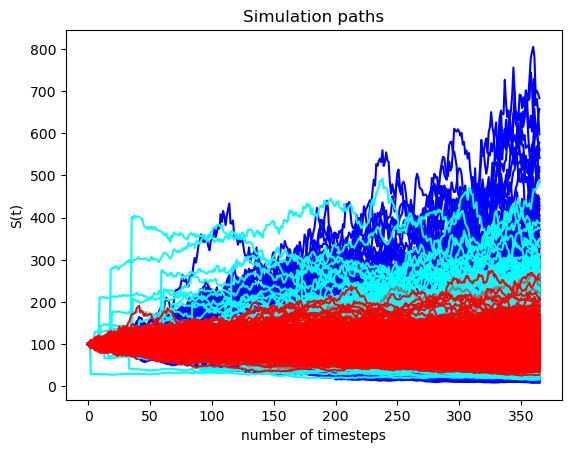

In [68]:
np.random.seed(123)
n = 365
T = n/365
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 30 days
n_sims = 1000
S0 = 100.#24.6144
K = S0

paths_Heston = Hest.simulate(timegrid, S0=S0, v0=model.v0, M=n_sims,n=n,model_name='Heston')
paths_HestonWithJumps = HestwJ.simulate(timegrid, S0=S0, v0=model.v0, M=n_sims,n=n,model_name='Heston')
paths_BNS = BNSm.simulate(timegrid, S0=S0, v0=model.v0, M=n_sims,n=n,model_name='BNS')

plt.figure()

plt.plot(paths_Heston[:,:], color = 'blue')
plt.plot(paths_HestonWithJumps[:,:], color = 'cyan')
plt.plot(paths_BNS[:,:],color='grey')


n_sims = 1
for j in range(len(xStrikes)):
    for i in range(len(ttm)):
        model = GBM(0.,theo[i][1][j])
        path_GBM = model.simulate(timegrid, S0=S0, v0=model.v0, M=n_sims,n=n,model_name='GBM')
        plt.plot(path_GBM,color='red')


plt.xlabel('number of timesteps')
plt.ylabel('S(t)')
plt.title('Simulation paths')

